# same as 02b but getting precip values as outputs

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing the libraries

%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import xarray as xr
import xcdat as xc
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [3]:
mpl.rcParams['font.family'] = 'Droid Sans'
mpl.rcParams['font.size'] = 12
# Edit axes parameters
mpl.rcParams['axes.linewidth'] = 1.5
# Tick properties
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.direction'] = 'out'

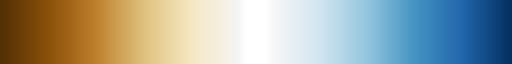

In [4]:
n = 35
diff = 0.5
cmap = plt.cm.BrBG
cmap2 = plt.cm.RdBu
lower = cmap(np.linspace(0, diff, n))
white = np.ones((2, 4))
upper = cmap2(np.linspace(1-diff, 1, n))
colors = np.vstack((lower, white, white, upper))
BrBU = mpl.colors.LinearSegmentedColormap.from_list('map_white', colors)
BrBU

In [5]:
import os

In [6]:
model_list = sorted(os.listdir('/scratch/ob22/as8561/data/preproc/'))[1:]
# model_list2 = sorted(os.listdir('/scratch/ob22/as8561/data/preproc/'))[18:]
model_list#.extend(model_list2)

['ACCESS-CM2',
 'ACCESS-ESM1-5',
 'AWI-CM-1-1-MR',
 'AWI-ESM-1-1-LR',
 'BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CAS-ESM2-0',
 'CESM2',
 'CESM2-FV2',
 'CESM2-WACCM',
 'CESM2-WACCM-FV2',
 'CMCC-CM2-HR4',
 'CMCC-CM2-SR5',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 'CanESM5',
 'E3SM-1-1',
 'E3SM-1-1-ECA',
 'EC-Earth3',
 'EC-Earth3-Veg',
 'EC-Earth3-Veg-LR',
 'FGOALS-f3-L',
 'FGOALS-g3',
 'FIO-ESM-2-0',
 'GFDL-CM4',
 'GFDL-ESM4',
 'GISS-E2-1-G',
 'GISS-E2-1-G-CC',
 'GISS-E2-1-H',
 'HadGEM3-GC31-LL',
 'HadGEM3-GC31-MM',
 'IITM-ESM',
 'INM-CM4-8',
 'INM-CM5-0',
 'IPSL-CM6A-LR',
 'KACE-1-0-G',
 'MCM-UA-1-0',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM-1-2-HAM',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NESM3',
 'NorCPM1',
 'NorESM2-LM',
 'NorESM2-MM',
 'SAM0-UNICON',
 'TaiESM1',
 'UKESM1-0-LL',
 'obs',
 'rean']

In [7]:
len(model_list)

54

In [8]:
# models to reject
model_list[25], model_list[38]

('FIO-ESM-2-0', 'MCM-UA-1-0')

In [9]:
up_model_list = [model for model in model_list if model not in ['FIO-ESM-2-0', 'MCM-UA-1-0']]
model_list = up_model_list
model_list, len(model_list)

(['ACCESS-CM2',
  'ACCESS-ESM1-5',
  'AWI-CM-1-1-MR',
  'AWI-ESM-1-1-LR',
  'BCC-CSM2-MR',
  'BCC-ESM1',
  'CAMS-CSM1-0',
  'CAS-ESM2-0',
  'CESM2',
  'CESM2-FV2',
  'CESM2-WACCM',
  'CESM2-WACCM-FV2',
  'CMCC-CM2-HR4',
  'CMCC-CM2-SR5',
  'CNRM-CM6-1',
  'CNRM-CM6-1-HR',
  'CNRM-ESM2-1',
  'CanESM5',
  'E3SM-1-1',
  'E3SM-1-1-ECA',
  'EC-Earth3',
  'EC-Earth3-Veg',
  'EC-Earth3-Veg-LR',
  'FGOALS-f3-L',
  'FGOALS-g3',
  'GFDL-CM4',
  'GFDL-ESM4',
  'GISS-E2-1-G',
  'GISS-E2-1-G-CC',
  'GISS-E2-1-H',
  'HadGEM3-GC31-LL',
  'HadGEM3-GC31-MM',
  'IITM-ESM',
  'INM-CM4-8',
  'INM-CM5-0',
  'IPSL-CM6A-LR',
  'KACE-1-0-G',
  'MIROC-ES2L',
  'MIROC6',
  'MPI-ESM-1-2-HAM',
  'MPI-ESM1-2-HR',
  'MPI-ESM1-2-LR',
  'MRI-ESM2-0',
  'NESM3',
  'NorCPM1',
  'NorESM2-LM',
  'NorESM2-MM',
  'SAM0-UNICON',
  'TaiESM1',
  'UKESM1-0-LL',
  'obs',
  'rean'],
 52)

In [91]:
import climtas
from scipy import stats
# import seaborn as sns
import pandas as pd
from dateutil.relativedelta import relativedelta
import regionmask

def find_indices(nino_events, nina_events):
    nino_idx = []
    nina_idx = []
    for i in range(len(nino_events)):
        start_en = nino_events['time'].to_numpy()[i]
        end_en = nino_events['event_duration'].to_numpy()[i]
        for j in range(end_en):
            nino_idx.append(start_en+j)
    for i in range(len(nina_events)):
        start_ln = nina_events['time'].to_numpy()[i]
        end_ln = nina_events['event_duration'].to_numpy()[i]
        for j in range(end_ln):
            nina_idx.append(start_ln+j)
    return nino_idx, nina_idx

###

def get_event_indices(nino_anom, threshold, min_duration, rolling_period):
    # import climtas
    nino_events = climtas.event.find_events(nino_anom.rolling(time=rolling_period).mean('time') > threshold, min_duration=min_duration)
    nina_events = climtas.event.find_events(nino_anom.rolling(time=rolling_period).mean('time') < -threshold, min_duration=min_duration)
    nino_idx, nina_idx = find_indices(nino_events, nina_events)
    enso_idx = np.sort(np.concatenate((nino_idx, nina_idx)))
    total = np.arange(0, len(nino_anom))
    neut_idx = np.delete(total, enso_idx)
    return nino_idx, nina_idx, neut_idx

###

# functions to calculate correlation value
def get_corr_1d(x, y):
    statistic, _ = stats.spearmanr(x, y)
    return statistic


def get_pval_1d(x, y):
    _, pval = stats.spearmanr(x, y)
    return pval


def get_corr(x, y, dim):
    return xr.apply_ufunc(get_corr_1d, x, y, input_core_dims=[[dim], [dim]], vectorize=True, dask = 'parallelized')


def get_pval(x, y, dim):
    return xr.apply_ufunc(get_pval_1d, x, y, input_core_dims=[[dim], [dim]], vectorize=True, dask = 'parallelized')

####

def reorder(da):
    da['time'] = pd.date_range('1900-01-01', '2015-01-01', freq='1M')

    custom = da.sel(time=da.time.dt.month.isin([6,7,8,9,10,11,12,1,2,3,4,5]))
    # convert cftime to datetime
    datetimeindex = custom.indexes['time']#.to_datetimeindex() 
    # custom['time'] = pd.to_datetime(datetimeindex)
    
    # Add custom group by year functionality
    custom_year = custom['time'].dt.year
    
    # convert time type to pd.Timestamp
    time1 = [pd.Timestamp(i) for i in custom_year['time'].values] 
    # time1 = [pd.Timestamp(i) for i in custom_year['time'].values] 
    
    # Add year to Timestamp objects when month is before Jan. (relativedelta does not work from np.datetime64)
    time2 = [i + relativedelta(years=1) if i.month>=6 else i for i in time1] 
    custom['time'] = time2
    return custom

####


def calc_anom(
    input_da,
    base_start_date: str = "1960-01-01",
    base_end_date: str = "1990-01-01",
    start_year: str = "1900-01-01",
    end_year: str = "2015-01-01",
    # var = "Temperature",
    # units = 'K'
):

    # define the base climatology
    base_clim = input_da.sel(time=slice(base_start_date, base_end_date))

    # calculate the monthly climatology for the base years
#     da_clim_coarsen = base_clim.coarsen(time=12)
    da_clim = base_clim.groupby("time.month").mean("time")
    da_anom = input_da.sel(time = slice(start_year, end_year)).groupby("time.month") - da_clim
    
    return da_anom

####

In [11]:
# Function to preprocess the regridded data


import xarray as xr
from statsmodels.tsa.seasonal import STL
import pymannkendall as mk

def detrend1d(arr, period = 9*12):
    res = STL(arr, period = period).fit()
    arr_det = arr - res.trend
    return arr_det
    
def detrend1d_check(arr, period = 9):
    # if np.nansum(arr) != 0:
    #     trend = mk.hamed_rao_modification_test(arr).trend
    # else:
    #     trend = 'no trend'
    # if trend != 'no trend':
    #     res = STL(arr, period = period).fit()
    #     arr_det = arr - res.trend
    #     return arr_det
    # else:
    #     return arr
    res = STL(arr, period = period).fit()
    arr_det = arr - res.trend
    return arr_det

# def detrend_separate(da, period=9):
#     trend = da.rolling(time = period*12).mean('time')
#     da_detrend = da - trend
#     return da_detrend
def detrend_separate(da, dim):
    return xr.apply_ufunc(detrend1d, da, input_core_dims=[[dim]], output_core_dims=[[dim]])
    
def detrend_separate_check(da, dim):
    return xr.apply_ufunc(detrend1d_check, da, input_core_dims=[[dim]], output_core_dims=[[dim]])

In [12]:
def extract_results_parallel(var, nino34, dmi):
    weights = np.cos(np.deg2rad(var.lat))
    weights.name = 'weights'
    # reorder the vars
    var = var.weighted(weights).mean(('lat', 'lon'))
    return var.to_numpy(), nino34.to_numpy(), dmi.to_numpy()


def calc_data_res_parallel(params):
    base_loc = '/scratch/ob22/as8561/data/preproc/'
    model = params[0]
    region = params[1]
    # get all the data
    precip = xr.open_dataset(base_loc + f'{model}/precip.nc').precip.sel(time = slice('1900', '2015'))#.load()
    precip = precip.assign_coords({"lon": (((precip.lon + 180) % 360) - 178.5)})
    precip_anom = precip.sortby(precip.lon)
    #
    nino34 = xr.open_dataset(base_loc + f'{model}/nino.nc').nino.sel(time = slice('1900', '2015'))#.load()
    dmi = xr.open_dataset(base_loc + f'{model}/dmi.nc').dmi.sel(time = slice('1900', '2015'))#.load()
    # mask the land area firt
    land_mask = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask_3D(precip, wrap_lon=False, drop=False)
    precip_land = precip.where(land_mask.isel(region=0))
    # mask for the ar6 land regions
    ar6_mask = regionmask.defined_regions.ar6.land.mask_3D(precip_land, wrap_lon=False, drop=False)
    # ar6_list = regionmask.defined_regions.ar6.land.to_dataframe()['names'].to_numpy()
    out_precip, out_nino, out_dmi = extract_results_parallel(precip_land.where(ar6_mask.isel(region=region)), nino34, dmi)
    return out_precip, out_nino, out_dmi

In [13]:
from multiprocessing import Pool
import itertools

In [14]:
region_list = regionmask.defined_regions.ar6.land.to_dataframe().index.to_numpy()

In [16]:
param_arr = [model_list, region_list]

In [17]:
param_list = list(itertools.product(*param_arr))

In [18]:
name_list = ['precip', 'nino', 'dmi']

In [19]:
len(name_list)

3

In [20]:
time = xr.open_dataset('/scratch/ob22/as8561/data/preproc/ACCESS-CM2/precip.nc').sel(time = slice('1900', '2015')).time.to_numpy()
time

array(['1900-01-16T12:00:00.000000000', '1900-02-15T00:00:00.000000000',
       '1900-03-16T12:00:00.000000000', ...,
       '2014-10-16T12:00:00.000000000', '2014-11-16T00:00:00.000000000',
       '2014-12-16T12:00:00.000000000'], dtype='datetime64[ns]')

In [21]:
def convert_to_da(arr, name):
    return xr.DataArray(
        data = arr,
        dims = ["time", "region", "model"],
        coords = dict(
            time = (["time"], time),
            region = (["region"], region_list),
            model = (["model"], model_list),
        ),
        name = name
    )

# def convert_to_da_base(arr, name):
#     return xr.DataArray(
#         data = arr,
#         dims = ["season", "region", "model"],
#         coords = dict(
#             season = (["season"], ['djf', 'jja', 'mam', 'son']),
#             region = (["region"], region_list),
#             model = (["model"], model_list),
#         ),
#         name = name
#     )

In [23]:
res_arr = []
with Pool() as pool:
    i = 0
    for res in pool.imap(calc_data_res_parallel, param_list):
        res_arr.append(res)
        print(f'completed {i+1}/{len(model_list)*len(region_list)}', end='\r')
        i += 1

In [25]:
# res_arr = np.array(res_arr)
da_arr = []
precip_arr = np.empty((1380, len(model_list)*len(region_list)))
nino_arr = np.empty((1380, len(model_list)*len(region_list)))
dmi_arr = np.empty((1380, len(model_list)*len(region_list)))
# base_arr = np.empty((4, 1472))

for i in range(len(model_list)*len(region_list)):
    precip_arr[:, i] = np.array(res_arr)[:, 0][i]
    nino_arr[:, i] = np.array(res_arr)[:, 1][i]
    dmi_arr[:, i] = np.array(res_arr)[:, 2][i]
    # base_arr[:, i] = np.array(res_arr)[:, 2][i]
    
da_precip = convert_to_da(np.reshape(precip_arr, (1380, len(region_list), len(model_list)), order = 'F'), name_list[0])
da_nino = convert_to_da(np.reshape(nino_arr, (1380, len(region_list), len(model_list)), order = 'F'), name_list[1])
da_dmi = convert_to_da(np.reshape(dmi_arr, (1380, len(region_list), len(model_list)), order = 'F'), name_list[2])
# da_base = convert_to_da_base(np.reshape(base_arr, (4, 46, 32), order = 'F'), name_list[2])

In [26]:
ds=xr.merge([da_precip, da_nino, da_dmi])

In [27]:
ds

<xarray.Dataset>
Dimensions:  (time: 1380, region: 46, model: 52)
Coordinates:
  * time     (time) datetime64[ns] 1900-01-16T12:00:00 ... 2014-12-16T12:00:00
  * region   (region) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
  * model    (model) <U16 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'obs' 'rean'
Data variables:
    precip   (time, region, model) float64 35.41 25.97 25.1 ... 26.33 nan 19.94
    nino     (time, region, model) float64 -0.6088 0.3745 ... 1.018 1.018
    dmi      (time, region, model) float64 -0.2605 0.2285 ... 0.1592 0.1592

In [38]:
ds.isel(model=-2, region=-2).precip

<xarray.DataArray 'precip' (time: 1380)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * time     (time) datetime64[ns] 1900-01-16T12:00:00 ... 2014-12-16T12:00:00
    region   int64 44
    model    <U16 'obs'

In [39]:
ds.to_netcdf('./data/result/raw.nc')

### start here

In [15]:
raw = xr.open_dataset('./data/result/raw.nc')
raw

<xarray.Dataset>
Dimensions:  (time: 1380, region: 46, model: 52)
Coordinates:
  * time     (time) datetime64[ns] 1900-01-16T12:00:00 ... 2014-12-16T12:00:00
  * region   (region) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
  * model    (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'obs' 'rean'
Data variables:
    precip   (time, region, model) float64 ...
    nino     (time, region, model) float64 ...
    dmi      (time, region, model) float64 ...

In [16]:
import seaborn as sns

In [17]:
raw.time

<xarray.DataArray 'time' (time: 1380)>
array(['1900-01-16T12:00:00.000000000', '1900-02-15T00:00:00.000000000',
       '1900-03-16T12:00:00.000000000', ..., '2014-10-16T12:00:00.000000000',
       '2014-11-16T00:00:00.000000000', '2014-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1900-01-16T12:00:00 ... 2014-12-16T12:00:00

In [18]:
for i in range(len(model_list)):
    print(i, float(raw.isel(model = i).precip.max()))

0 588.3083736637542
1 601.34501760692
2 383.5801073568664
3 455.2905299589998
4 557.3485876877928
5 751.2511765734428
6 405.245309960938
7 370.9416584717902
8 630.8651319017457
9 668.8546005961421
10 600.2114525256169
11 530.195958098798
12 602.4109337467019
13 576.6398526745943
14 514.8894514095168
15 440.1913079326293
16 541.2583885248391
17 572.5253515150779
18 558.3522001090996
19 705.3035567569697
20 607.9927000528721
21 538.5830630415127
22 639.0541952121562
23 622.3561166446623
24 650.7397335903449
25 493.0527144264452
26 521.9416097058051
27 559.1413559643089
28 566.7105956846784
29 597.2382446466473
30 507.53371936702837
31 596.5899365526338
32 447.08961459655546
33 521.7771223518322
34 641.4622077330228
35 619.8525509360088
36 524.132931891067
37 547.34771834009
38 613.0714165799823
39 553.1188324129731
40 416.06793521029323
41 473.78198648765664
42 495.49972020544504
43 528.1072958564482
44 482.44730289481373
45 554.9322169891593
46 550.6185100851288
47 645.4600805776735
48 

<AxesSubplot:ylabel='Density'>

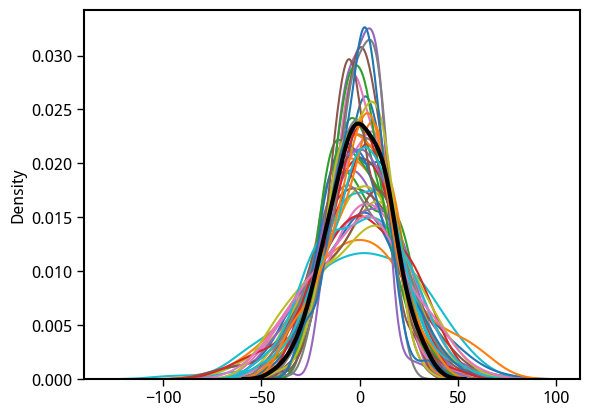

In [19]:
jja = raw.isel(region=37, model=-2).precip.time.dt.month.isin([6,7,8])
for model in range(0,42,1):
    pr = detrend_separate_check(calc_anom(raw.isel(region=37, model=model).precip).sel(time=jja).groupby('time.year').mean('time'), 'year')
    sns.kdeplot(pr)
pr = detrend_separate_check(calc_anom(raw.isel(region=37, model=-2).precip).sel(time=jja).groupby('time.year').mean('time'), 'year')
sns.kdeplot(pr,color='k', lw=3.0)

In [20]:
naus  = raw.isel(region=39, model = -2)
naus

<xarray.Dataset>
Dimensions:  (time: 1380)
Coordinates:
  * time     (time) datetime64[ns] 1900-01-16T12:00:00 ... 2014-12-16T12:00:00
    region   int64 39
    model    <U3 'obs'
Data variables:
    precip   (time) float64 ...
    nino     (time) float64 ...
    dmi      (time) float64 ...

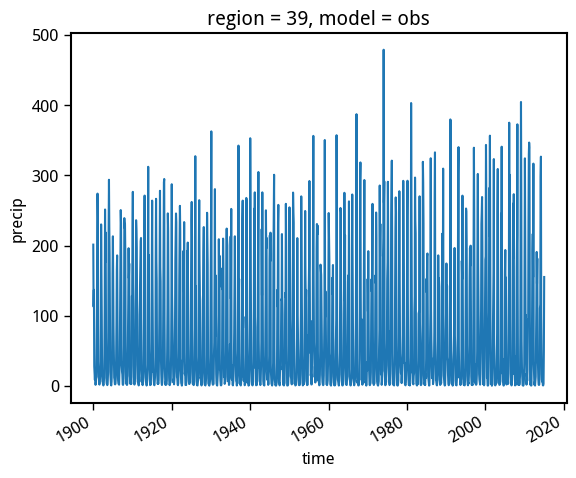

In [21]:
naus.precip.plot()

In [105]:
def calc_res(precip, nino34, season_str):
    precip_anom = calc_anom(precip)
    threshold = float(nino34.std())
    # nino34 = reorder(nino34).sel(time = sondjf).groupby('time.year').mean('time')[:-1]
    if season_str == 'ANN':
        precip_clim = float(reorder(precip).groupby('time.year').mean('time').mean('year'))
        precip_std = float(reorder(precip).groupby('time.year').mean('time').std('year'))
        precip_det = detrend_separate_check(reorder(precip_anom).groupby('time.year').mean('time'), dim='year').sel(year = slice('1900', '2015'))
        nino34 = reorder(nino34).groupby('time.year').mean('time').sel(year = slice('1900', '2015'))
        en_events = float(nino34.where(nino34 > threshold).count())
        ln_events = float(nino34.where(nino34 < -threshold).count())
        neut_events = float(nino34.where((nino34 < 0.5*threshold) & (nino34 > -0.5*threshold)).count())
        corr = float(get_corr(nino34, precip_det, 'year'))
        pval = float(get_pval(nino34, precip_det, 'year'))
        nino = float(precip_det.where(nino34 > threshold).mean('year'))/precip_std
        nina = float(precip_det.where(nino34 < -threshold).mean('year'))/precip_std
        neut = float(precip_det.where((nino34 > -0.5*threshold) & (nino34 < 0.5*threshold)).mean('year'))/precip_std
        enc_pval = float(stats.mannwhitneyu(precip_det.where(nino34 > threshold, drop=True).to_numpy()/precip_std, precip_det.where((nino34 > -0.5*threshold) & (nino34 < 0.5*threshold), drop=True).to_numpy()/precip_std).pvalue)
        lnc_pval = float(stats.mannwhitneyu(precip_det.where(nino34 < -threshold, drop=True).to_numpy()/precip_std, precip_det.where((nino34 > -0.5*threshold) & (nino34 < 0.5*threshold), drop=True).to_numpy()/precip_std).pvalue)
        enc = nino - neut
        lnc = nina - neut
        asymm = (enc + lnc)/2
    else:
        season_names = ['DJF', 'MAM', 'JJA', 'SON']
        season_months = [[12,1,2], [3,4,5], [6,7,8], [9,10,11]]
        season_dict = dict(zip(season_names, season_months))
        season_month = season_dict[season_str]
        season = precip_anom.time.dt.month.isin(season_month)
        precip_clim = float(precip.groupby('time.season').mean('time').sel(season = season_str))
        precip_std = float(precip.groupby('time.season').std('time').sel(season = season_str))
        if season_str == 'DJF':
            precip_det = detrend_separate_check(reorder(precip_anom).sel(time = season).groupby('time.year').mean('time'), dim='year').sel(year = slice('1901', '2015'))
            nino34 = reorder(nino34).sel(time = season).groupby('time.year').mean('time').sel(year = slice('1901', '2015'))
        else:
            precip_det = detrend_separate_check(precip_anom.sel(time = season).groupby('time.year').mean('time'), dim='year').sel(year = slice('1900', '2015'))
            nino34 = nino34.sel(time = season).groupby('time.year').mean('time').sel(year = slice('1900', '2015'))
        en_events = float(nino34.where(nino34 > threshold).count())
        ln_events = float(nino34.where(nino34 < -threshold).count())
        neut_events = float(nino34.where((nino34 < 0.5*threshold) & (nino34 > -0.5*threshold)).count())
        corr = float(get_corr(nino34, precip_det, 'year'))
        pval = float(get_pval(nino34, precip_det, 'year'))
        nino = float(precip_det.where(nino34 > threshold).mean('year'))/precip_std
        nina = float(precip_det.where(nino34 < -threshold).mean('year'))/precip_std
        neut = float(precip_det.where((nino34 > -0.5*threshold) & (nino34 < 0.5*threshold)).mean('year'))/precip_std
        enc = nino - neut
        lnc = nina - neut
        try:
            enc_pval = float(stats.mannwhitneyu(precip_det.where(nino34 > threshold, drop=True).to_numpy()/precip_std, precip_det.where((nino34 > -0.5*threshold) & (nino34 < 0.5*threshold), drop=True).to_numpy()/precip_std).pvalue)
        except ValueError:
            enc_pval = np.NaN
            nino = 0
            enc = 0
        try:
            lnc_pval = float(stats.mannwhitneyu(precip_det.where(nino34 < -threshold, drop=True).to_numpy()/precip_std, precip_det.where((nino34 > -0.5*threshold) & (nino34 < 0.5*threshold), drop=True).to_numpy()/precip_std).pvalue)
        except ValueError:
            lnc_pval = np.NaN
            nina = 0
            lnc = 0
        asymm = (enc + lnc)/2
    return dict(
        precip_clim = precip_clim,
        precip_std = precip_std,
        # precip_skw = precip_skw,
        corr = corr,
        pval = pval,
        nino = nino,
        nina = nina,
        neut = neut,
        enc_pval = enc_pval,
        lnc_pval = lnc_pval,
        enc = enc,
        lnc = lnc,
        asymm = asymm,
        threshold = threshold,
        en_events = en_events,
        ln_events = ln_events,
        neut_events  = neut_events
    )

In [106]:
res = calc_res(naus.precip, naus.nino, season_str='SON')
res

{'precip_clim': 28.859850443882845,
 'precip_std': 29.321852804624545,
 'corr': -0.6853310187011759,
 'pval': 2.9568920350711334e-17,
 'nino': -0.2875118737260936,
 'nina': 0.5797004692617129,
 'neut': -0.07380080654270087,
 'enc_pval': 0.003148678418617446,
 'lnc_pval': 1.8844622428045572e-06,
 'enc': -0.21371106718339272,
 'lnc': 0.6535012758044138,
 'asymm': 0.21989510431051051,
 'threshold': 0.7031515257285177,
 'en_events': 17.0,
 'ln_events': 16.0,
 'neut_events': 43.0}

In [107]:
ar6_list = regionmask.defined_regions.ar6.land.to_dataframe().names.to_numpy()
season_list = ['ANN', 'DJF', 'MAM', 'JJA', 'SON']

In [108]:
std = np.empty((len(model_list), len(ar6_list), len(season_list)))
clim = np.empty((len(model_list), len(ar6_list), len(season_list)))
# skw = np.empty((32, 46, 5))  
corr = np.empty((len(model_list), len(ar6_list), len(season_list)))
pval = np.empty((len(model_list), len(ar6_list), len(season_list)))
nino = np.empty((len(model_list), len(ar6_list), len(season_list)))
nina = np.empty((len(model_list), len(ar6_list), len(season_list)))
neut = np.empty((len(model_list), len(ar6_list), len(season_list)))
enc_pval = np.empty((len(model_list), len(ar6_list), len(season_list)))
lnc_pval = np.empty((len(model_list), len(ar6_list), len(season_list)))
threshold = np.empty((len(model_list)))
en_events = np.empty((len(model_list), len(season_list)))
ln_events = np.empty((len(model_list), len(season_list)))
neut_events = np.empty((len(model_list), len(season_list)))
for i in range(len(model_list)):
    for j in range(len(ar6_list)):
        for k in range(len(season_list)):
            precip = raw.precip.isel(model=i, region=j)
            nino34 = raw.nino.isel(model = i, region=j)
            res = calc_res(precip, nino34, season_str=season_list[k])
            std[i, j, k] = res['precip_std']
            clim[i, j, k] = res['precip_clim']
            # skw[i, j, k] = res['precip_skw']
            corr[i, j, k] = res['corr']
            pval[i, j, k] = res['pval']
            nino[i, j, k] = res['nino']
            nina[i, j, k] = res['nina']
            neut[i, j, k] = res['neut']
            enc_pval[i, j, k] = res['enc_pval']
            lnc_pval[i, j, k] = res['lnc_pval']
            en_events[i, k] = res['en_events']
            ln_events[i, k] = res['ln_events']
            neut_events[i, k] = res['neut_events']
    threshold[i] = res['threshold']
    print(f'Completed model {i+1}/{len(model_list)}')
print('COMPLETE')

Completed model 1/52
Completed model 2/52
Completed model 3/52
Completed model 4/52
Completed model 5/52
Completed model 6/52
Completed model 7/52
Completed model 8/52
Completed model 9/52
Completed model 10/52
Completed model 11/52
Completed model 12/52
Completed model 13/52
Completed model 14/52
Completed model 15/52
Completed model 16/52
Completed model 17/52
Completed model 18/52
Completed model 19/52
Completed model 20/52
Completed model 21/52
Completed model 22/52
Completed model 23/52
Completed model 24/52
Completed model 25/52
Completed model 26/52
Completed model 27/52
Completed model 28/52
Completed model 29/52
Completed model 30/52
Completed model 31/52
Completed model 32/52
Completed model 33/52
Completed model 34/52
Completed model 35/52
Completed model 36/52
Completed model 37/52
Completed model 38/52
Completed model 39/52
Completed model 40/52
Completed model 41/52
Completed model 42/52
Completed model 43/52
Completed model 44/52
Completed model 45/52
Completed model 46/

In [111]:
main_ds = xr.Dataset(
    data_vars=dict(
        std_dev = (["model", "region", "season"], std),
        clim = (["model", "region", "season"], clim),
        # skw = (["model", "region", "season"], skw),
        corr_coef = (["model", "region", "season"], corr),
        pval = (["model", "region", "season"], pval),
        nino = (["model", "region", "season"], nino),
        nina = (["model", "region", "season"], nina),
        neut = (["model", "region", "season"], neut),
        enc_pval = (["model", "region", "season"], enc_pval),
        lnc_pval = (["model", "region", "season"], lnc_pval),
        en_events = (["model", "season"], en_events),
        ln_events = (["model", "season"], ln_events),
        neut_events = (["model", "season"], neut_events),
        threshold = (["model"], threshold)
    ),
    coords=dict(
        model=(["model"], model_list),
        region=(["region"], ar6_list),
        season=(["season"], season_list)
    )
)

In [112]:
main_ds.to_netcdf('./data/result/out_conc.nc')

In [113]:
out = xr.open_dataset('./data/result/out_conc.nc')

In [114]:
out

<xarray.Dataset>
Dimensions:      (model: 52, region: 46, season: 5)
Coordinates:
  * model        (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'obs' 'rean'
  * region       (region) object 'Greenland/Iceland' ... 'W.Antarctica'
  * season       (season) object 'ANN' 'DJF' 'MAM' 'JJA' 'SON'
Data variables: (12/13)
    std_dev      (model, region, season) float64 ...
    clim         (model, region, season) float64 ...
    corr_coef    (model, region, season) float64 ...
    pval         (model, region, season) float64 ...
    nino         (model, region, season) float64 ...
    nina         (model, region, season) float64 ...
    ...           ...
    enc_pval     (model, region, season) float64 ...
    lnc_pval     (model, region, season) float64 ...
    en_events    (model, season) float64 ...
    ln_events    (model, season) float64 ...
    neut_events  (model, season) float64 ...
    threshold    (model) float64 ...

In [64]:
out.isel(model=3, region=39).pval.values

array([1.02102858e-08,            nan, 2.20378035e-02, 3.11966608e-03,
       2.63388456e-13])

In [35]:
import pandas as pd
import seaborn as sns

In [36]:
out.isel(model = -2, region = 41).nino.values

array([-0.46171605, -0.20533445,  0.11666737, -0.50962314, -0.37571344])

In [37]:
out.isel(model = -2, region = 41).nina.values

array([1.31291566, 0.33803572, 0.34830991, 0.1391895 , 0.63520748])

In [38]:
out.isel(model = -2, region = 41).clim.values

array([50.12550615, 80.22618705, 45.79987006, 32.9335844 , 41.74128961])

In [39]:
out.isel(model = -2, region = 41).std_dev.values

array([11.88721416, 43.93319983, 33.88057036, 23.08540151, 27.42588118])

In [40]:
out.isel(model = -2, region = 41).pval.values

array([6.60574810e-10, 1.40025092e-03, 9.96060063e-01, 5.41176821e-08,
       3.89244186e-11])

In [41]:
data_df = out.isel(model = -2, region = 41).to_dataframe()

In [42]:
data_df['asymm'] = ((data_df['nino'] - data_df['neut']) + (data_df['nina'] - data_df['neut']))/2

Text(0.5, 1.0, 'E.Australia - obs')

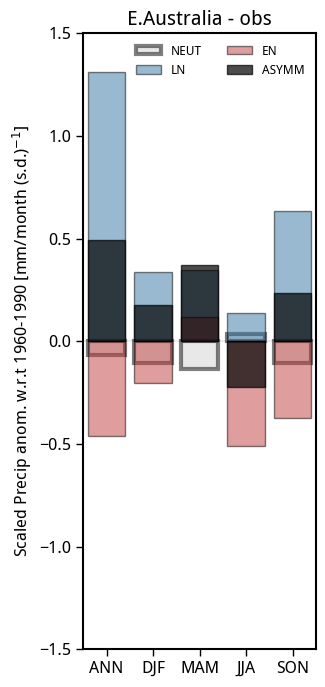

In [43]:
plt.figure(figsize=(3,8))
sns.barplot(data_df, y = 'neut', x = data_df.index, color='lightgray', linewidth=3.0, edgecolor='k', alpha=0.5, label = 'NEUT')
sns.barplot(data_df, y = 'nina', x = data_df.index, color='tab:blue', linewidth=1.0, edgecolor='k', alpha=0.5, label='LN')
sns.barplot(data_df, y = 'nino', x = data_df.index, color='tab:red', linewidth=1.0, edgecolor='k', alpha=0.5, label='EN')
sns.barplot(data_df, y = 'asymm', x = data_df.index, color='k', linewidth=1.0, edgecolor='k', alpha=0.7, label='ASYMM')
plt.ylim(-1.5, 1.5)
plt.axhline(0.0, lw=0.1, color='k')
plt.legend(frameon=False, fontsize=9, ncol=2)
plt.ylabel('Scaled Precip anom. w.r.t 1960-1990 [mm/month (s.d.)$^{-1}$]')
plt.xlabel('')
plt.title(data_df['region'][0] + ' - ' + data_df['model'][0])
# plt.savefig('./PhD/enso_precip_asymmetry/images/pres/eaus_obs_seasonal.png', dpi=300, bbox_inches='tight')

In [44]:
data_df = out.isel(season = 0, region = 41).to_dataframe()

In [45]:
data_df.head()

,std_dev,clim,corr_coef,pval,nino,nina,neut,enc_pval,lnc_pval,en_events,ln_events,neut_events,threshold,region,season
model,,,,,,,,,,,,,,,
ACCESS-CM2,16.653444,56.763124,-0.512890,3.947775e-09,-0.436846,1.113775,-0.161732,0.133335,0.000008,14.0,16.0,58.0,0.779278,E.Australia,ANN
ACCESS-ESM1-5,17.911413,65.411993,-0.517503,2.707108e-09,-0.748120,0.559324,-0.041158,0.003229,0.020617,15.0,14.0,48.0,0.818852,E.Australia,ANN
AWI-CM-1-1-MR,10.400973,34.176003,-0.624864,6.552235e-14,-1.059920,0.771334,0.134038,0.000003,0.032652,16.0,12.0,54.0,0.907350,E.Australia,ANN
AWI-ESM-1-1-LR,12.525844,52.170155,-0.472218,8.720111e-08,-0.777169,0.798494,0.002730,0.001658,0.005414,14.0,14.0,59.0,0.726897,E.Australia,ANN
BCC-CSM2-MR,13.301257,66.296550,-0.514374,3.498762e-09,-0.679445,1.221777,-0.158786,0.092769,0.000010,8.0,15.0,47.0,0.905592,E.Australia,ANN


In [46]:
data_df['asymm'] = ((data_df['nino'] - data_df['neut']) + (data_df['nina'] - data_df['neut']))/2

In [47]:
data_df.head()

,std_dev,clim,corr_coef,pval,nino,nina,neut,enc_pval,lnc_pval,en_events,ln_events,neut_events,threshold,region,season,asymm
model,,,,,,,,,,,,,,,,
ACCESS-CM2,16.653444,56.763124,-0.512890,3.947775e-09,-0.436846,1.113775,-0.161732,0.133335,0.000008,14.0,16.0,58.0,0.779278,E.Australia,ANN,0.500196
ACCESS-ESM1-5,17.911413,65.411993,-0.517503,2.707108e-09,-0.748120,0.559324,-0.041158,0.003229,0.020617,15.0,14.0,48.0,0.818852,E.Australia,ANN,-0.053240
AWI-CM-1-1-MR,10.400973,34.176003,-0.624864,6.552235e-14,-1.059920,0.771334,0.134038,0.000003,0.032652,16.0,12.0,54.0,0.907350,E.Australia,ANN,-0.278331
AWI-ESM-1-1-LR,12.525844,52.170155,-0.472218,8.720111e-08,-0.777169,0.798494,0.002730,0.001658,0.005414,14.0,14.0,59.0,0.726897,E.Australia,ANN,0.007932
BCC-CSM2-MR,13.301257,66.296550,-0.514374,3.498762e-09,-0.679445,1.221777,-0.158786,0.092769,0.000010,8.0,15.0,47.0,0.905592,E.Australia,ANN,0.429952


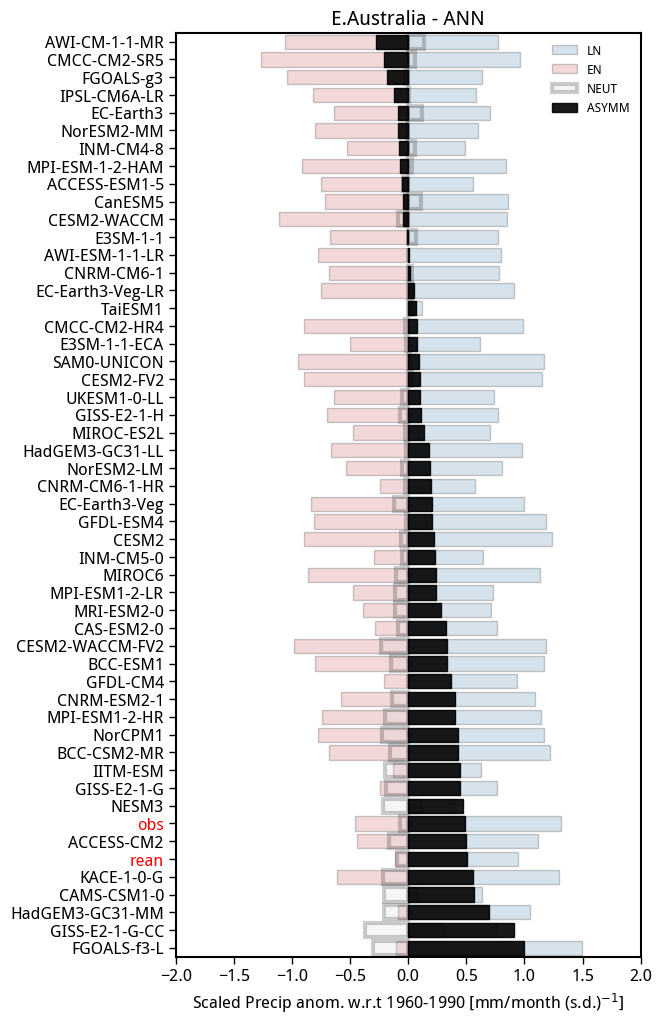

In [49]:
plt.figure(figsize=(6,12))
sns.barplot(data_df.sort_values('asymm'), x = 'nina', y = data_df.sort_values('asymm').index, color='tab:blue', linewidth=1.0, edgecolor='k', alpha=0.2, label='LN')
sns.barplot(data_df.sort_values('asymm'), x = 'nino', y = data_df.sort_values('asymm').index, color='tab:red', linewidth=1.0, edgecolor='k', alpha=0.2, label='EN')
sns.barplot(data_df.sort_values('asymm'), x = 'neut', y = data_df.sort_values('asymm').index, color='lightgray', linewidth=3.0, edgecolor='k', alpha=0.2, label='NEUT')
sns.barplot(data_df.sort_values('asymm'), x = 'asymm', y = data_df.sort_values('asymm').index, color='k', linewidth=1.0, edgecolor='k', alpha=0.9, label = 'ASYMM')
plt.xlim(-2.0, 2.0)
plt.axvline(0.0, lw=0.1, color='k')
plt.legend(frameon=False, fontsize=9, ncol=1)
plt.xlabel('Scaled Precip anom. w.r.t 1960-1990 [mm/month (s.d.)$^{-1}$]')
plt.ylabel('')
plt.title(data_df['region'][0] + ' - ' + data_df['season'][0])
plt.gca().get_yticklabels()[-6].set_color('red')
plt.gca().get_yticklabels()[-8].set_color('red')
# plt.savefig('./PhD/enso_precip_asymmetry/images/pres/eaus_son_model.png', dpi=300, bbox_inches='tight')